# Mario map
### Trying to auto generate mario-like maps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import random
from simpledbf import Dbf5

In [2]:
map_tif_path = glob.glob("map_data/gm_lc_v3/*.tif")
im_full = [Image.open(path) for path in map_tif_path]

/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (933120000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [3]:
scale_1 = 2
im_full_scaled = [im.resize((int(im.size[0]/scale_1),int(im.size[1]/scale_1)),
                                resample = PIL.Image.NEAREST) for im in im_full]

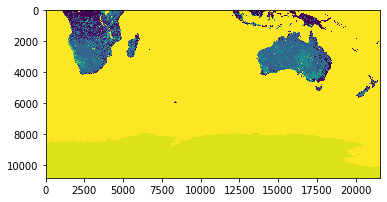

In [4]:
plt.imshow(im_full_scaled[3])
plt.show()

In [5]:
im_full_scaled

[<PIL.Image.Image image mode=L size=21600x10800 at 0x105B7C8D0>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x11038CA20>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x10735BB70>,
 <PIL.Image.Image image mode=L size=21600x10800 at 0x10B72B5C0>]

In [6]:
[im_full_scaled[i].size for i in range(4)]

[(21600, 10800), (21600, 10800), (21600, 10800), (21600, 10800)]

In [7]:
im_full_scaled[0].info

{'compression': 'tiff_lzw', 'dpi': (1, 1), 'resolution': (1, 1)}

In [8]:
im = Image.new("L", (im_full_scaled[0].size[0]*2,im_full_scaled[0].size[1]*2))
width = im_full_scaled[1].size[0]
height = im_full_scaled[1].size[1]
im.paste(im_full_scaled[0],(0,0))
im.paste(im_full_scaled[1],(width,0))
im.paste(im_full_scaled[2],(0,height))
im.paste(im_full_scaled[3],(width,height))
im_master = im

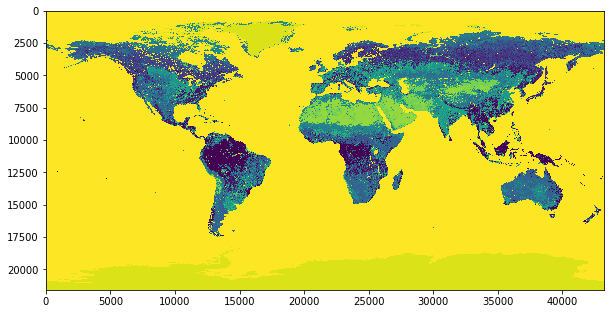

In [9]:
fig = plt.figure(figsize = (10,20))
plt.imshow(im_master, aspect = "equal")
plt.show()

3600 20400 14400 10800


/anaconda3/lib/python3.6/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (155520000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


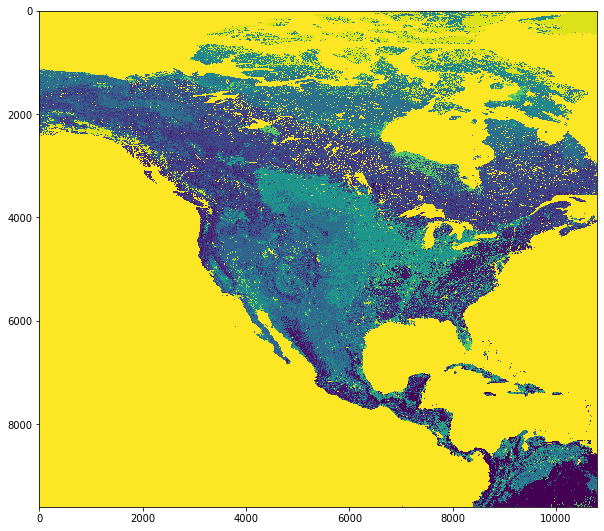

In [64]:
fig = plt.figure(figsize = (10,20))

lat_top = 65
lat_bottom = 40
lon_left = -15
lon_right = 15

lat_top = 80
lat_bottom = 0
lon_left = -150
lon_right = -60

# lat_top = 89
# lat_bottom = -89
# lon_left = -179
# lon_right = 179


w, h = im_master.size[0], im_master.size[1]

l = int((lon_left + 180) * w /360)
u = int((lat_top + 90)*h/180)
r = int((lon_right + 180) * w /360)
d = int((lat_bottom + 90)*h/180)

print(l,u,r,d)
im = im_master.crop((l, h - u, r, h - d))


plt.imshow(im, aspect = "equal")
plt.show()

In [65]:
data = np.array(im)
data = np.flip(data, axis = 1)
data = data.swapaxes(0,1)
data = np.flip(data, axis = 0)

### Now to get mario sprites

sprites/zanzio.png


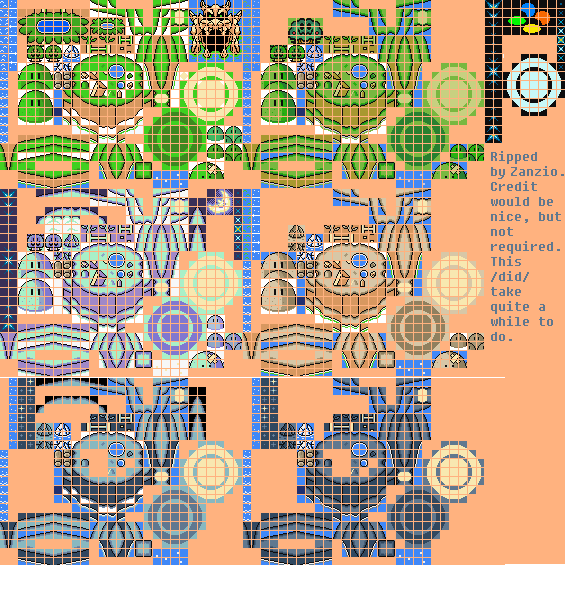

In [66]:
tile_sheet_path = glob.glob("sprites/zanzio.png")[0]
print(tile_sheet_path)
tile_sheet = Image.open(tile_sheet_path)
tile_sheet

sprites/zanzio.png


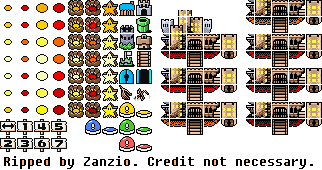

In [67]:
level_sheet_path = glob.glob("sprites/levela.png")[0]
print(tile_sheet_path)
level_sheet = Image.open(level_sheet_path)
level_sheet

In [68]:
def get_sprite_small(x, y, tile_sheet = tile_sheet):
    l = x * 9
    u = y * 9
    r = l + 8
    d = u + 8
    return tile_sheet.crop((l,u,r,d))

def get_sprite(x, y, w = 1, h = 1, tile_sheet = tile_sheet):
    if w == 1 and h == 1:
        return get_sprite_small(x,y, tile_sheet)
    im = Image.new("RGBA", (w * 8, h * 8))
    for i in range(w):
        for j in range(h):
            s = get_sprite_small(x + i,y + j,tile_sheet)
            im.paste(s, (i*8,j*8))
    return im

def get_sprite_level(x,y):
    l = x*17
    u = y*17
    r = l + 16
    d = u + 16
    return level_sheet.crop((l,u,r,d))

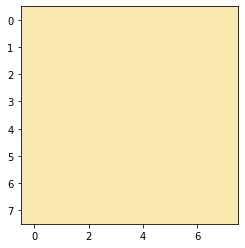

In [69]:
plt.imshow(get_sprite(23,10, h = 1, w = 1))
plt.show()

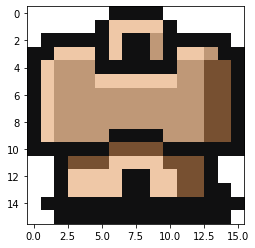

In [70]:
plt.imshow(get_sprite_level(8,2))
plt.show()

### Nice: sprites are loaded
### Now to NOT USE PYGAME
#### Using Image class as a canvas instead....

In [101]:
# tiles_x = 100
tiles_x = 100
tiles_y = int(tiles_x * im.size[1] / im.size[0])
canvas = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
print(tiles_y)

88


In [102]:
canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))

In [103]:

def draw_sprite(canvas, sprite, t_x, t_y):
    canvas.paste(sprite, (int(t_x*8), int(t_y * 8)), mask = sprite)
    return canvas

def compLayers(layers):

    canvas = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
    for l in layers[::-1]:
        canvas = Image.alpha_composite(canvas, l)
    return canvas


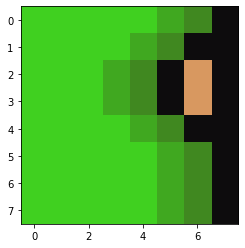

In [104]:
plt.imshow(get_sprite(15,8, h = 1, w = 1))
plt.show()

In [105]:
from scipy.ndimage import gaussian_filter as gf

dataPixPerTile = int(im.size[0]/tiles_x) #Very approx, avoid


terrain0 = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
canvas = terrain0

DATA_WATER = 20
DATA_URBAN = 18

def t2x(tx): #Convert tile coords to map coords
    return int(tx * im.size[0]/tiles_x)
def t2y(ty):
    return int(ty * im.size[1]/tiles_y)

def rand_rot(im):
    n = random.choice([0,1,2,3])
    return im.rotate(90 * n)


            
def draw_grass(canvas, tx,ty, toy = 0, tox = 0):
    grass_sprites = [get_sprite(10+ tox,7+toy), get_sprite(11+tox,7+toy)]
    s = random.choices(grass_sprites, [10,1])[0]
    s = rand_rot(s)
    draw_sprite(canvas, s,tx,ty)


#Get all tiles that are land
land = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if (d == DATA_WATER).mean() < 0.7:
            land[tx,ty] = True
land = gf(land.astype(float), 0.7) > 0.5 #Smooth a lil
#Smooth more:
for i in range(4):
    for tx in range(tiles_x):
        for ty in range(tiles_y):
            if land[tx,ty] == False: continue
            #At edge
            if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
                draw_grass(canvas, tx, ty)
                continue
            u = land[tx,ty - 1]
            d = land[tx,ty +1]
            l = land[tx -1, ty]
            r = land[tx + 1, ty]
            if (not (l or r)) or (not (u or d)):
                land[tx,ty] = 0 

        

def draw_elevated(canvas, land, floor = "water", highland = "grass", h = 2, offset = False, temp= 0):
    #Draw green ground
    for tx in range(tiles_x):
        for ty in range(tiles_y):
            if land[tx,ty] == False: continue
            #At edge
            if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
                draw_grass(canvas, tx, ty)
                continue
            u = land[tx,ty - 1]
            d = land[tx,ty +1]
            l = land[tx -1, ty]
            r = land[tx + 1, ty]
            ul = land[tx -1, ty - 1]
            ur = land[tx +1, ty - 1]
            dl = land[tx -1, ty + 1]
            dr = land[tx +1, ty + 1]
            
            if offset: ty -= offset
                
            toy1 = 0
            tox1 = 0
            if highland == "grass":
                toy1 += 0 #y tile offset, from tile sheet
            else:
                toy1 += 42
            
            toy2 = 0
            if floor == "water":
                toy2 += 0
            else:
                toy2 += -1
            
            if temp is not 0 and not highland == "stone":
                temp = temp
                if temp == -1:
                    toy1 += 21
                elif temp == 1:
                    tox1 += 27
                elif temp == 2:
                    tox1 += 27
                    toy1 += 21
            
            if not d:
                if l and r:
                    #Horizontal continue
                    draw_sprite(canvas, random.choice([get_sprite(11+tox1,11+toy1), get_sprite(12+tox1,11+toy1)]), tx, ty)
                    for i in range(h):
                        draw_sprite(canvas, get_sprite(10+tox1,12+toy1), tx, ty+i+1)
                    s = random.choice([get_sprite(11+tox1,15+toy1+toy2), get_sprite(12+tox1,15+toy1+toy2)])
                    draw_sprite(canvas, s, tx, ty+h+1)
                elif l and not r:
                    #Begin up right
                    if dr and ul:
                        draw_sprite(canvas, get_sprite(16+tox1,10+toy1), tx, ty)
                        for i in range(h-1):
                            draw_sprite(canvas, get_sprite(10+tox1,12+toy1), tx, ty+i+1)
                    else:
                        draw_sprite(canvas, get_sprite(15+tox1,10+toy1), tx, ty)
                        for i in range(h-1):
                            draw_sprite(canvas, get_sprite(12+tox1,12+toy1), tx, ty+i+1)
                    s = get_sprite(15+tox1,13+toy1+toy2)
                    draw_sprite(canvas, s, tx, ty+h)
                elif not l and r:
                    #Begin up left
                    if ul and dr:
                        draw_sprite(canvas, get_sprite(7+tox1,10+toy1), tx, ty)
                        for i in range(h-1):
                            draw_sprite(canvas, get_sprite(10+tox1,12+toy1), tx, ty+i+1)
                    else:
                        draw_sprite(canvas, get_sprite(8+tox1,10+toy1), tx, ty)
                        for i in range(h-1):
                            draw_sprite(canvas, get_sprite(11+tox1,12+toy1), tx, ty+i+1)
                    s = get_sprite(8+tox1,13+toy1+toy2)
                    draw_sprite(canvas, s, tx, ty+h)
            #Side panels
            elif u and not r:
                draw_sprite(canvas, random.choice((get_sprite(15+tox1,9+toy1),get_sprite(15+tox1,8+toy1))), tx, ty)
            elif u and not l:
                draw_sprite(canvas, random.choice((get_sprite(8+tox1,9+toy1),get_sprite(8+tox1,8+toy1))), tx, ty)
            #Top panels
            elif d and not u:
                if l and r:
                    #Horizontal continue
                    draw_sprite(canvas, random.choice([get_sprite(11+tox1,6+toy1), get_sprite(12+tox1,6+toy1)]), tx, ty)
                elif l and not r:
                    #Begin up right
                    draw_sprite(canvas, get_sprite(15+tox1,7+toy1), tx, ty)
                elif  not l and r:
                    #Begin up left
                    draw_sprite(canvas, get_sprite(8+tox1,7+toy1), tx, ty)
                elif ul and l and not r:
                    #Continue up right
                    draw_sprite(canvas, get_sprite(16+tox1,10+toy1), tx, ty)
                elif ur and r and not l:
                    #Continue up left
                    draw_sprite(canvas, get_sprite(7+tox1,10+toy1), tx, ty)
                else:
                    draw_grass(canvas, tx, ty, toy = toy1, tox = tox1)
            #Catch other shit, discard
            elif (not u) or (not d) or (not l) or (not r):
                land[tx,ty] = False
                continue
            else:
                draw_grass(canvas, tx, ty, toy = toy1, tox = tox1)


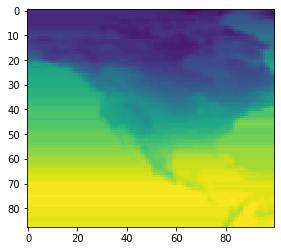

In [106]:
#CLIMATE SHIT:
temp_data = np.load("map_data/temps.npy")
x0 = int((lon_left+180)*temp_data.shape[1] / 360)
x1 = int((lon_right+180)*temp_data.shape[1] / 360)
y0 = temp_data.shape[0] - int((lat_bottom+90)*temp_data.shape[0] / 180)
y1 = temp_data.shape[0] - int((lat_top+90)*temp_data.shape[0] / 180)

temp_data = temp_data[y1:y0, x0:x1]
temp_data = temp_data.T

temp_data = gf(temp_data, 5)

temp_tiles = np.full((tiles_x, tiles_y), -100)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        s_x = lambda x: int(x * temp_data.shape[0]/tiles_x)
        s_y = lambda y: int(y * temp_data.shape[1]/tiles_y)
        sample = temp_data[s_x(tx):s_x(tx+1), s_y(ty):s_y(ty+1)]
        if 0 in sample.shape:
            print(tx,ty)
            temp_tiles[tx,ty] = temp_data[s_x(tx), s_y(ty)]
        temp_tiles[tx,ty] = sample.mean()

plt.imshow(temp_tiles.T)
plt.show()

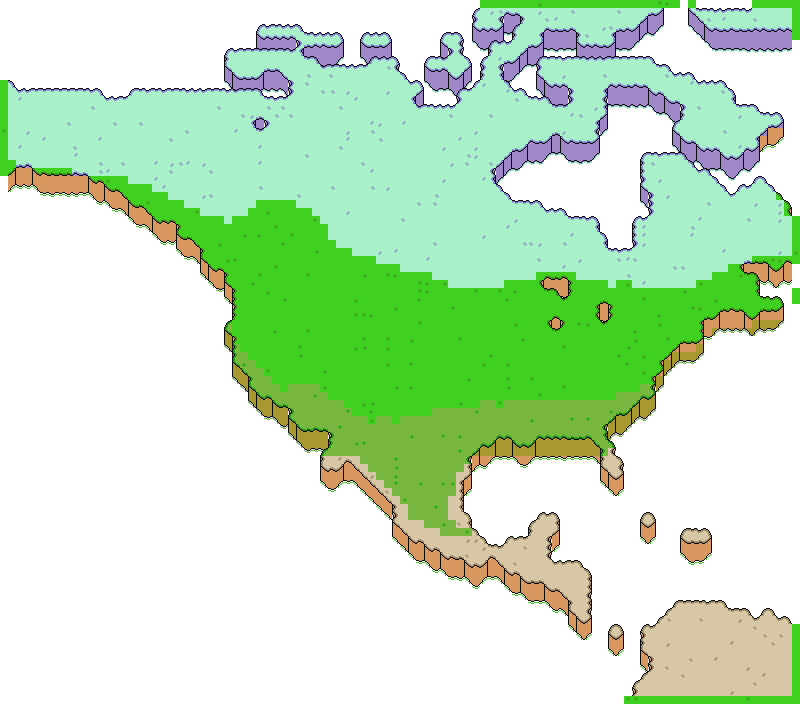

In [107]:
#Do temps here:
terrain0 = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
canvas = terrain0

snow_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
grass_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
darkgrass_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
desert_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))

draw_elevated(snow_layer, land, h = 2, temp = -1) #Grass
draw_elevated(grass_layer, land, h = 2, temp = 0) #Grass
draw_elevated(darkgrass_layer, land, h = 2, temp = 1) #Grass
draw_elevated(desert_layer, land, h = 2, temp = 2) #Grass

climate_tiles = np.full((tiles_x,tiles_y), 0)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        temp = temp_tiles[tx,ty]
        snow = snow_layer.crop((tx*8,ty*8,(tx+1)*8,(ty+1)*8))
        grass = grass_layer.crop((tx*8,ty*8,(tx+1)*8,(ty+1)*8))
        darkgrass = darkgrass_layer.crop((tx*8,ty*8,(tx+1)*8,(ty+1)*8))
        desert = desert_layer.crop((tx*8,ty*8,(tx+1)*8,(ty+1)*8))
        
        blend_range = 0.1
        
        desert_t = 15
        darkgrass_t = 5
        grass_t = -15
        
        if temp > desert_t:
            climate_tiles[tx,ty] = 2
            s = desert
        elif temp > darkgrass_t:
            climate_tiles[tx,ty] = 1
            alpha = np.clip((desert_t - temp)/blend_range,0,1)
            s = Image.blend(desert, darkgrass, alpha)
        elif temp > grass_t:
            climate_tiles[tx,ty] = 0
            alpha = np.clip((darkgrass_t - temp)/blend_range,0,1)
            s = Image.blend(darkgrass, grass, alpha)
        else:
            climate_tiles[tx,ty] = -1
            alpha = np.clip((grass_t - temp)/blend_range,0,1)
            s = Image.blend(grass, snow, alpha)
        
        draw_sprite(canvas, s, tx,ty)


canvas

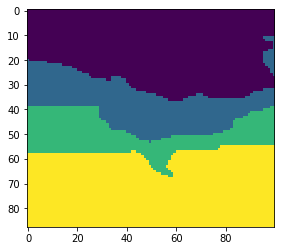

In [108]:
plt.imshow(climate_tiles.T)
plt.show()

In [109]:
sea_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
canvas = sea_layer
canvas.paste((68,139,244),(0,0,canvas.size[0], canvas.size[1]))
#Make ocean pretty
land_gf = gf(land.astype(float), 5)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if land[tx,ty] == True: continue
        if land_gf[tx,ty] > 0.2: continue
        wave_sprites = [get_sprite(0,0),get_sprite(0,1),get_sprite(0,2)]
        s = wave_sprites[0]
        draw_sprite(canvas, s,tx,ty)    



In [110]:
#random shit sorry
def near_sea(tx, ty, s = 1):
    tx = int(tx)
    ty = int(ty)
    l = land[tx-s:tx+s,ty-s:ty+s]
    return  np.any(np.logical_not(l))

def near_edge(map, tx, ty, s = 1):
    tx = int(tx)
    ty = int(ty)
    l = map[tx-s:tx+s,ty-s:ty+s]
    return  np.any(np.logical_not(l))

def shrink(tiles, s = 1):
    assert s >= 0
    if s == 0: return tiles
    if not s == 1:
        tiles = shrink(tiles, s - 1)
    padded = np.pad(tiles, 1, "constant", constant_values = (False))
    mask = np.logical_and(np.logical_and(
        np.logical_and(np.logical_and(tiles,padded[1:-1,2:]),
                       padded[1:-1,:-2]),padded[2:,1:-1]),padded[:-2,1:-1])
    return mask

def expand(tiles, s = 1):
    assert s >= 1
    if not s == 1:
        tiles = shrink(tiles, s - 1)
    padded = np.pad(tiles, 1, "constant", constant_values = (False))
    mask = np.logical_or(np.logical_or(
        np.logical_or(np.logical_or(tiles,padded[1:-1,2:]),
                       padded[1:-1,:-2]),padded[2:,1:-1]),padded[:-2,1:-1])
    return mask
    

### Doing elevation here now

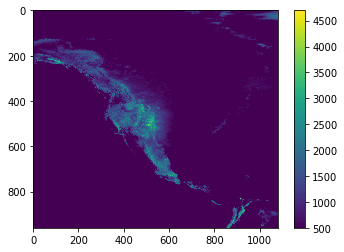

In [111]:
import rasterio
path = glob.glob("map_data/alwdgg.tiff")[0]
elev = rasterio.open(path).read(1)
x0 = int((lon_left+180)*elev.shape[1] / 360)
x1 = int((lon_right+180)*elev.shape[1] / 360)
y0 = elev.shape[0] - int((lat_bottom+90)*elev.shape[0] / 180)
y1 = elev.shape[0] - int((lat_top+90)*elev.shape[0] / 180)

elev = elev[y1:y0, x0:x1]

plt.imshow(np.clip(elev, 500, None))
plt.colorbar()
plt.show()

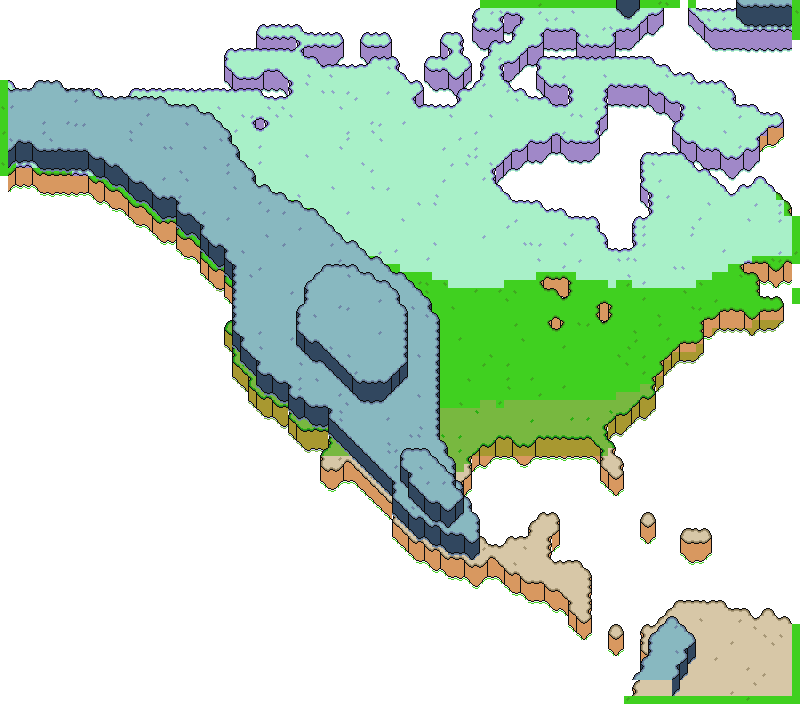

In [157]:
def t2ex(tx): #Convert tile coords to elev coords
    return int(tx * elev.shape[1]/tiles_x)
def t2ey(ty):
    return int(ty * elev.shape[0]/tiles_y)

terrains = [terrain0.copy()]
elev_tiles_list = [land.copy()]
for j in range(3):
    terrain1 = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
    canvas = terrain1
    
    under = elev_tiles_list[-1] #The layer underneath this one
    
    padded = np.pad(under, 1, "constant", constant_values = (True))
    mask = np.logical_and(under, padded[1:-1,2:])

    #Get all tiles elevated by 1
    elev_tiles = np.full((tiles_x, tiles_y), False)
    for tx in range(tiles_x):
        for ty in range(tiles_y):
            e = elev.T[t2ex(tx):t2ex(tx+1),t2ey(ty):t2ey(ty+1)]
            if (e > (j+1)*1000).mean() > 0.2:
                elev_tiles[tx,ty] = True
    elev_tiles = np.logical_and(under, elev_tiles)
    elev_tiles = gf(elev_tiles.astype(float), 3) > 0.3 #Smooth a lil
    for i in range(4):
        elev_tiles = np.logical_and(elev_tiles, mask)
        for tx in range(tiles_x):
            for ty in range(tiles_y):
                if elev_tiles[tx,ty] == False: continue
                #At edge
                if tx == 0 or ty == 0 or tx == tiles_x - 1 or ty == tiles_y - 1:
                    continue
                u = elev_tiles[tx,ty - 1]
                d = elev_tiles[tx,ty +1]
                l = elev_tiles[tx -1, ty]
                r = elev_tiles[tx + 1, ty]
                if (not (l or r)) or (not (u or d)):
                    elev_tiles[tx,ty] = False
    draw_elevated(canvas, elev_tiles, floor = "grass", highland = "stone", offset = 2*j + 2, h = 2)
    terrains.append(canvas)
    elev_tiles_list.append(elev_tiles)
    
    
compLayers(terrains[::-1])

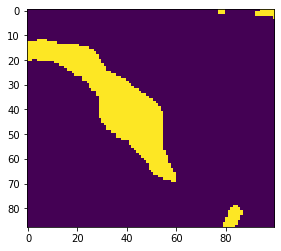

In [113]:
plt.imshow(elev_tiles_list[1].T)
plt.show()

### Scratch that, that looks trash. Use population data instead.

In [114]:
path = glob.glob("map_data/*s.dbf")[0]
df = Dbf5(path).to_dataframe()
print(path)

map_data/ne_10m_populated_places.dbf


### Trees

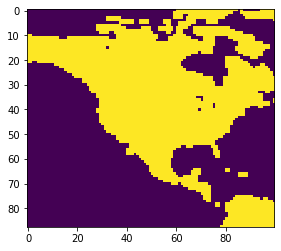

In [115]:
plt.imshow(elev_tiles_list[0].T)
plt.show()

### Cover in crops n shit

# Cities

In [116]:
path = glob.glob("map_data/*s.dbf")[0]
df = Dbf5(path).to_dataframe()

num_cities = 200

df = df[df.LATITUDE > lat_bottom]
df = df[df.LATITUDE < lat_top]
df = df[df.LONGITUDE > lon_left]
df = df[df.LONGITUDE < lon_right]
df = df[df.RANK_MAX > 8]

df["tx"] = (df['LONGITUDE'] - lon_left)/(lon_right - lon_left) * tiles_x
df["ty"] = tiles_y - (df['LATITUDE'] - lat_bottom)/(lat_top - lat_bottom) * tiles_y


df_ = df[["NAME","POP_MAX","RANK_MAX", "tx", "ty"]].sort_values(by = "POP_MAX")[-num_cities:]

In [117]:
np_df = df_.to_numpy()

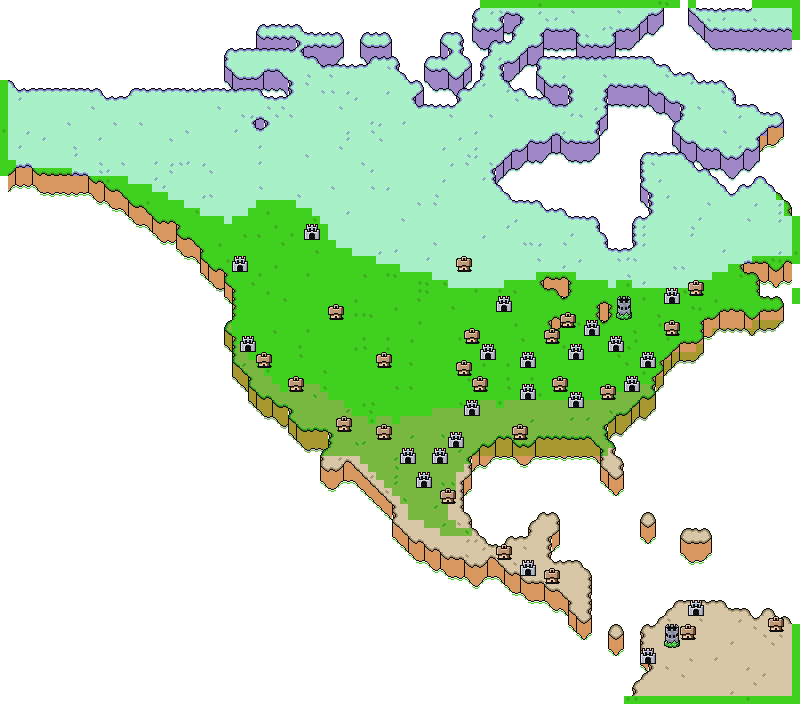

In [150]:
city_layers = [Image.new("RGBA", (tiles_x * 8, tiles_y * 8)) for n in range(len(terrains))]

np_df = np_df[np.argsort(np_df[:,1])][::-1] #Order by rank

na = np.newaxis

populated = np.full((tiles_x,tiles_y), False)

city_locs = np.full((num_cities, 2), -100)
for j in range(np_df.shape[0]):
    d = np_df[j]
    rank, tx, ty = d[2:5]
    tx, ty = int(tx), int(ty)
    #Check that not close to an already present city
    closest_dist = np.abs((city_locs - np.array((tx,ty))[na,:])).sum(axis = 1).min()
    if closest_dist < 4: continue
    
    max_nudge = 1
    if not land[tx, ty]: #shift city onto land
        area = land[tx-max_nudge:tx+max_nudge+1,ty-max_nudge:tx+max_nudge+1]
        if area.any():
            tx += np.argwhere(area)[0][0] - max_nudge
            ty += np.argwhere(area)[0][1] - max_nudge
        else:
            continue
        
    for i, terrain in enumerate(elev_tiles_list[::-1]):
        if terrain[tx,ty] == True:
            #CHECK THAT HAS SPACE:
            if shrink(terrain, s = 1)[tx,ty] == False: break
            if not i == 0:
                above = elev_tiles_list[::-1][i-1]
                if above[tx,ty-1] or above[tx,ty-2]: break
            canvas = city_layers[i]
            city_locs[j] = (tx,ty)
            populated[tx-1:tx+1, ty-1:ty+1] = True #So trees dont spawn onit
            if rank == 13:
                draw_sprite(canvas, get_sprite_level(7,1) , tx-1, ty-2 -1 - 2 * (len(terrains) - i - 1))
                draw_sprite(canvas, get_sprite_level(7,2) , tx-1, ty-1- 2 * (len(terrains) - i - 1))
            elif rank == 12:
                draw_sprite(canvas, get_sprite_level(8,0) , tx-1, ty-1- 2 * (len(terrains) - i - 1))
            else:
                draw_sprite(canvas, get_sprite_level(8,2) , tx-1, ty-1- 2 * (len(terrains) - i - 1))
            break
    
    
    

compLayers(city_layers + [terrain0])

### Comping

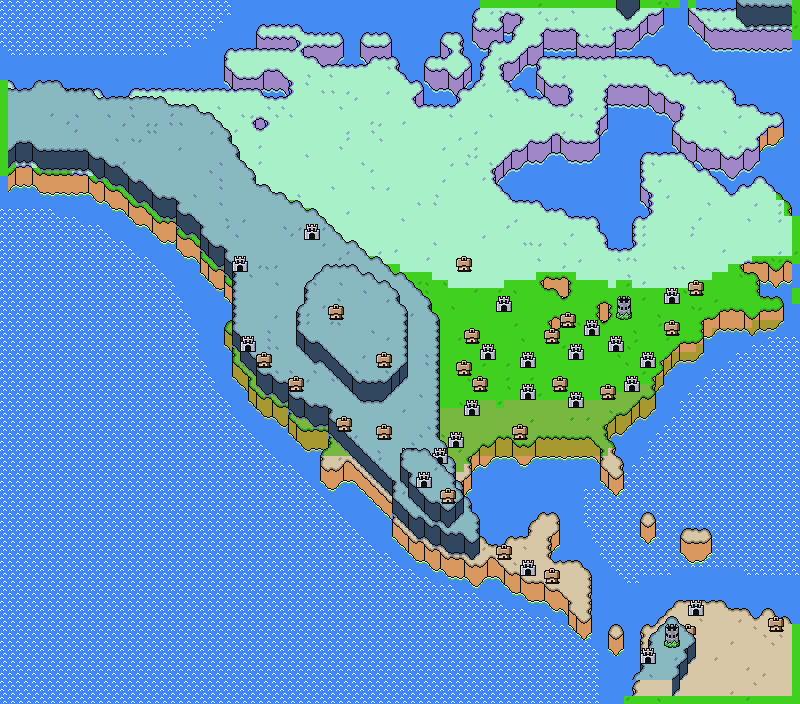

In [119]:

temp = []
for i in range(len(terrains)):
    temp.append(city_layers[i])
#     temp.append(tree_layers[i])
    temp.append(terrains[::-1][i])

layers = temp + [sea_layer]

compLayers(layers)

### TO DO: Change drawing completely
Have all objects from a certain level be added to a list, then draw that layer y-down as per.

### But for now, sea stuff.

In [120]:
sea_rocks_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
canvas = sea_rocks_layer

sea_rocks = np.full((tiles_x, tiles_y), False)
for tx in range(tiles_x):
    for ty in range(tiles_y):
        if tx < 2 or ty < 2 or tx > tiles_x -3 or ty > tiles_y - 3: continue
        e = elev.T[t2ex(tx):t2ex(tx+1),t2ey(ty):t2ey(ty+1)]
        if (e > 0).mean() > 0.1:
            if not land[tx,ty-5:ty+1].any():
                sea_rocks[tx,ty] = True

for tx in range(tiles_x)[::2]:
    for ty in range(tiles_y)[::2]:
        s = sea_rocks[tx:tx+2, ty:ty+2]
        l = land[tx-1:tx+1, ty:ty+2]
        if not np.any(s): continue
        if np.any(l): continue
        draw_sprite(canvas, get_sprite(7,5,h = 2, w = 2),tx-1,ty)

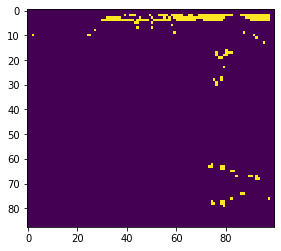

In [121]:

plt.imshow(sea_rocks.T)
plt.show()

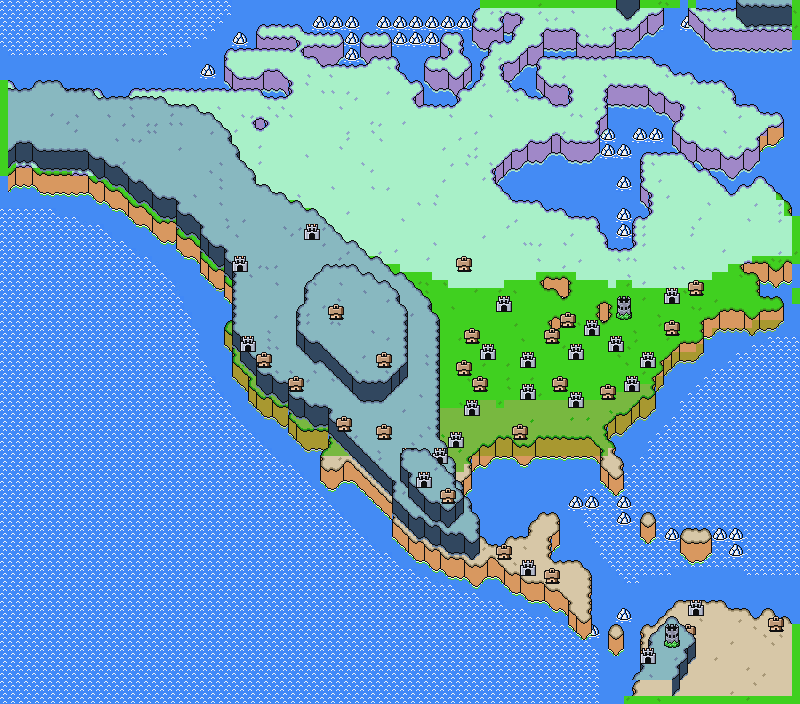

In [122]:
def compLayers(layers):

    canvas = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
    for l in layers[::-1]:
        canvas = Image.alpha_composite(canvas, l)
    return canvas

def fullComp():
    temp = []
    for i in range(len(terrains)):
        temp.append(city_layers[i])
#         temp.append(tree_layers[i])
        temp.append(terrains[::-1][i])
    layers = temp + [sea_rocks_layer,sea_layer]
    return compLayers(layers)

fullComp()

### Roads?!?!!

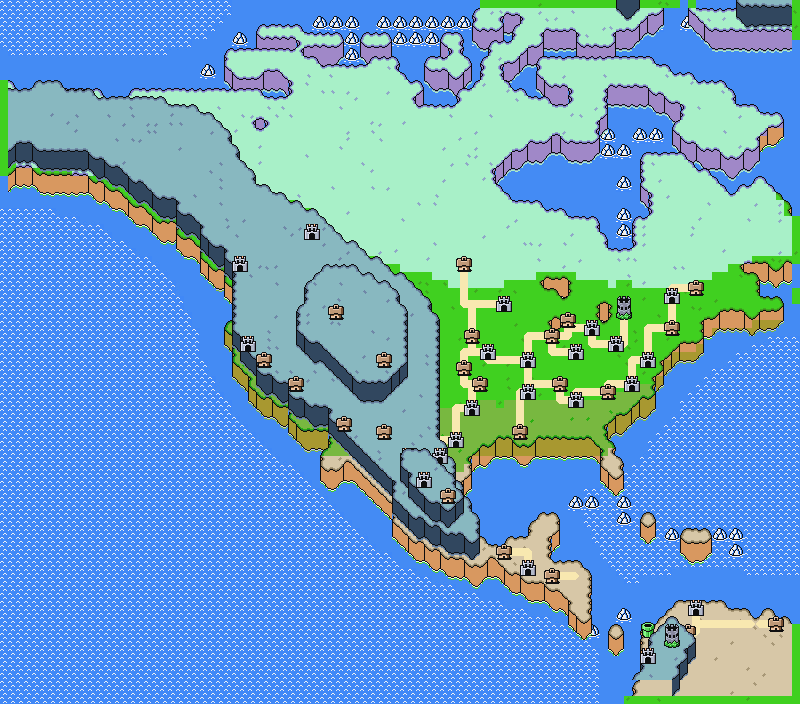

In [123]:
import scipy as sp

roads_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
pipes_layer = Image.new("RGBA", (tiles_x * 8, tiles_y * 8))
canvas = roads_layer

# x = np_df[:,3:5]
x = city_locs[city_locs[:,0] > -1] #All cities that were drawn
dist = sp.spatial.distance_matrix(x, x).astype(float)
mst = sp.sparse.csgraph.minimum_spanning_tree(dist)
connections = np.array(mst.nonzero()).T

x0 = x[connections[:,0]]
x1 = x[connections[:,1]]

roads = np.hstack((x0,x1)).reshape(-1,2,2)

s = get_sprite(20,8, h = 1, w = 1)
landshrink = shrink(land, s = 2)
for i, r in enumerate(roads):
    
    pipe_already_drawn = False
    
    
    #Makes sure to draw the "nicer" leg
    if (r[0,1]-tiles_y/2)**2 + (r[1,0]-tiles_x/2)**2 > (r[1,1]-tiles_y/2)**2 + (r[0,0]-tiles_x/2)**2:
        r = np.flip(r, axis = 0)
    #Check if in sea
    if landshrink[r[0,0],r[1,1]] and not landshrink[r[1,0],r[0,1]]:
        r = np.flip(r, axis = 0)
    
    
    for pair in ((0,1),(1,0)): #hax
        for n in np.linspace(int(r[0,pair[0]]), int(r[1,pair[0]]),200):
            tx, ty = n, int(r[pair[0],pair[1]])
            if pair[0]: tx,ty = ty,tx
            if not landshrink[int(tx),int(ty)]:
                if not pipe_already_drawn and shrink(land, s = 1)[int(tx),int(ty)]:
                    #Check that note too close to a city
                    dist = np.abs(np.array((tx,ty))[na,:]-x).sum(axis =1).min()
                    if dist > 2:
                        draw_sprite(pipes_layer, get_sprite_level(8,1), tx-.8,ty-1.3)
                    pipe_already_drawn = True
                continue
            draw_sprite(canvas, s, tx-.5,ty-.5)
            populated[int(tx)-1:int(tx)+1,int(ty)-1:int(ty)+1] = True
        pipe_already_drawn = False

        
#     draw_sprite(canvas, get_sprite(22,9,h = 3, w = 3), int(r[0,0])-1.5, int(r[0,1])-1.5)
#     draw_sprite(canvas, get_sprite(22,9,h = 3, w = 3), int(r[1,0])-1.5, int(r[1,1])-1.5)



temp = []
for i in range(len(terrains)):
    temp.append(city_layers[i])
    if i == len(terrains)-1: temp.append(pipes_layer)
#     temp.append(tree_layers[i])
    if i == len(terrains)-1: temp.append(roads_layer)
    temp.append(terrains[::-1][i])
layers =  temp + [sea_rocks_layer,sea_layer]
compLayers(layers)

In [124]:
x.shape

(46, 2)

### TODO:
- ~~Make roads better. Choose the better leg of the road to draw.~~
- Draw pipes if road long enough and stops: alter to add "long enough" condition.
- Change tileset if go south.
- Draw big tree guys sometimes.
- Draw door where path intersects mountain.
- Change tree spawning to occur after all other objects, and avoid.
- Add beaches somehow?

# Trees done as late as poss

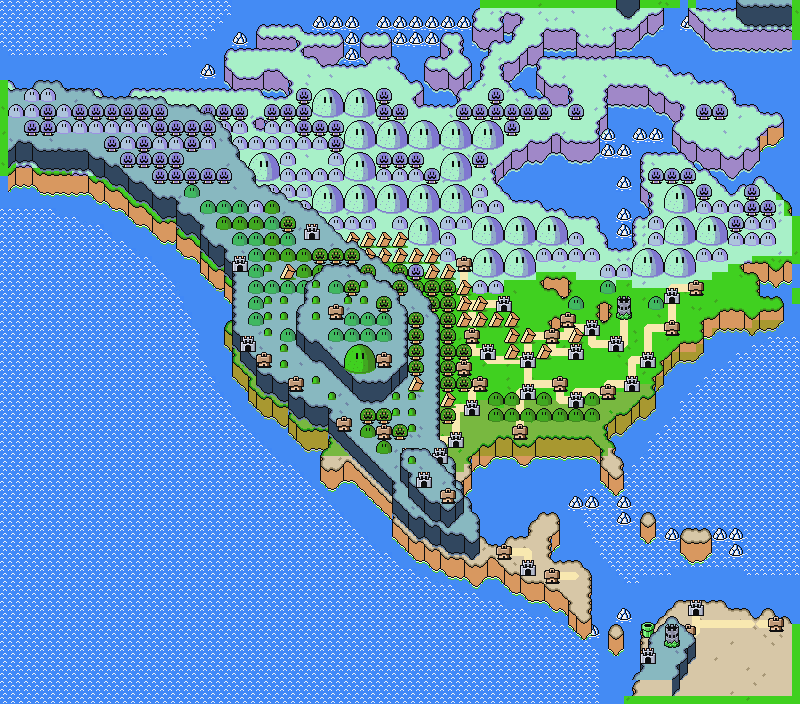

In [158]:
tree_layers = [Image.new("RGBA", (tiles_x * 8, tiles_y * 8)) for n in range(len(terrains))]


populated_layers_tree = [[np.full((tiles_x//2,tiles_y//2), False) for n in range(len(terrains))] for m in range(5)]

    
for tx in range(tiles_x)[::2]:
    for ty in range(tiles_y)[::2]:
        d = data[t2x(tx):t2x(tx+1),t2y(ty):t2y(ty+1)]
        if near_sea(tx,ty): continue
        if populated[tx-1:tx+1,ty-1:ty+1].any(): continue
        climate = climate_tiles[tx,ty]
        if climate == -1:
            toy = 21
        else:
#             continue
            toy = 0    
        
        tree_type = 0
        if (d == 8).mean() > 0.2: #Hervaceous: all over england
            tree_type = 0
            s =  get_sprite(5,5+toy, w = 2, h = 2)
        elif (d == 3).mean() > 0.2: #Needleleaf evergreen: all over america
            tree_type = 1
            if climate == 2:
                s =  get_sprite(23+27,16+21, w = 2, h = 2)
            else:
                s =  get_sprite(23,16+toy, w = 2, h = 2)
        elif (d == 6).mean() > 0.1: #Want it to be hotter trees, need sprite. 3 is spain
            tree_type = 2
            if climate == 2:
                s =  get_sprite(23+27,16+21, w = 2, h = 2)
            else:
                s =  get_sprite(23,14+toy, w = 2, h = 2)
        elif (d == 7).mean() > 0.1:
            tree_type = 3
            s =  get_sprite(9,9+toy, w = 1, h = 1)
        elif (d == 11).mean() > 0.5:
            tree_type = 4
            s =  get_sprite(10,9, w = 2, h = 2)
        else:
            continue

        
        #Work out what level/layer its on
        for i, terrain in enumerate(elev_tiles_list[::-1]):
            if terrain[tx,ty] == True:
                #CHECK THAT HAS SPACE:
                if shrink(terrain, s = 2)[tx,ty] == False: break
                if not terrain[tx-1:tx+2,ty].all(): break
                if not i == 0:
                    above = elev_tiles_list[::-1][i-1]
                    if above[tx,ty-1] or above[tx,ty-2]: break
                    if above[tx-1:tx+1,ty-1:ty+1].any(): break
                populated_layers_tree[tree_type][i][tx//2,ty//2] = True
                draw_sprite(tree_layers[i], s, tx -1, ty - 1 - 2 * (len(terrains) - i - 1))
                break


big_head_sprites = [get_sprite(x,y,4,4) for (x,y) in [(29,10),(2,10),(2,10),(29,10),(2,10)]]
for tx in range(tiles_x)[::4]:
    for ty in range(tiles_y)[::4]:
        for j, layers_populated in enumerate(populated_layers_tree):
            head = big_head_sprites[j]
            for i, layer in enumerate(layers_populated):
                if layer[tx//2:tx//2 + 2, ty//2:ty//2 + 2].all():
                    for x in range(32):
                        for y in range(32):
                            tree_layers[i].putpixel(((tx-1)*8 + x,(ty-1)*8 + y), (0,0,0,0))
                    if climate_tiles[tx,ty] == -1:
                        head = get_sprite(2,31,4,4)
                    elif climate_tiles[tx,ty] == 2:
                        head = get_sprite(29,31,4,4)
                    draw_sprite(tree_layers[i],head, tx-1, ty-1)
        
        
        
temp = []
for i in range(len(terrains)):
    temp.append(city_layers[i])
    if i == len(terrains)-1: temp.append(pipes_layer)
    temp.append(tree_layers[i])
    if i == len(terrains)-1: temp.append(roads_layer)
    temp.append(terrains[::-1][i])
layers =  temp + [sea_rocks_layer,sea_layer]
compLayers(layers)

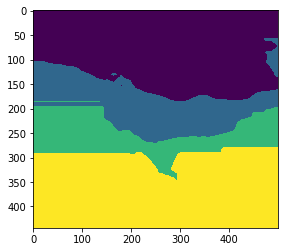

In [96]:
plt.imshow(climate_tiles.T)
plt.show()

# Bridges?!

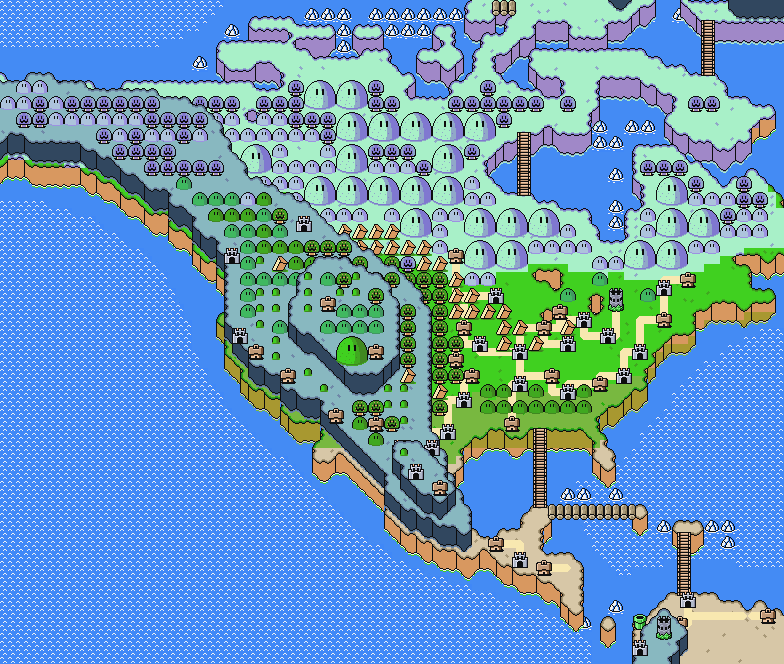

In [159]:
bridge_layers = [Image.new("RGBA", (tiles_x * 8, tiles_y * 8)) for n in range(len(terrains))]

bridge_locs = []

for i, terr in enumerate(elev_tiles_list[::-1]):
    for tx in range(2,tiles_x-2):
        for ty in range(2,tiles_y-2):
            if not (terr[tx-1:tx+2,ty].all() and not terr[tx,ty - 1]): continue
            if not terr[tx,:ty].any(): continue
            length = ty - np.argwhere(terr[tx,:ty])[-1][0]
            max_length = 12 + (1+i-len(terrains))*10
            if not(length < max_length  and length > 2): continue
            if not terr[tx-1:tx+2, ty - length].all(): continue
            if terr[tx-2:tx+3, ty-3:ty-1].any(): continue
            if len(bridge_locs):
                dist = np.abs(np.array(bridge_locs) - np.array((tx,ty))[na,:]).sum(axis = 1).min()
                if dist < 20: continue
            bridge_locs.append((tx,ty))
            for j in range(length-1):
                draw_sprite(bridge_layers[i], get_sprite_level(8,3),tx-.5, ty -j-1.5)
                
bridge_locs = []                
for i, terr in enumerate(elev_tiles_list[::-1]):
    for tx in range(2,tiles_x-2):
        for ty in range(2,tiles_y-2):
            if not terr[tx,ty-1:ty+2].all(): continue #If not on land
            if terr[tx+1,ty]: continue #Check actually water in front at least
            if not terr[tx+1:,ty].any(): continue #Check somewhere to land
            length = np.argwhere(terr[tx+1:,ty])[0,0]+1
            max_length = 12 + (1+i-len(terrains))*10
            if not(length < max_length  and length > 2): continue
            if not terr[tx + length, ty-1:ty+1].all(): continue #Check nice destination

            if terr[tx+1:tx+3, ty-3:ty+2].any(): continue #Check that enough clearance
                
            if len(bridge_locs):
                dist = np.abs(np.array(bridge_locs) - np.array((tx,ty))[na,:]).sum(axis = 1).min()
                if dist < 4: continue
            bridge_locs.append((tx,ty))
            for j in range((length)):
                draw_sprite(bridge_layers[i], get_sprite(6,8, h = 2),tx+j+.5, ty-1)
                
#Do same for sideways bridges


temp = []
for i in range(len(terrains)):
    temp.append(city_layers[i])
    if i == len(terrains)-1: temp.append(pipes_layer)
    temp.append(tree_layers[i])
    temp.append(bridge_layers[i])
    if i == len(terrains)-1: temp.append(roads_layer)
    temp.append(terrains[::-1][i])
layers =  temp + [sea_rocks_layer,sea_layer]
comp = compLayers(layers)
comp.crop((8,8,comp.size[0]-8, comp.size[1]-32))

In [98]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [99]:
np.arange(10)[4-1:4+2]

array([3, 4, 5])

In [100]:
np.arange(10)[2:3+1]

array([2, 3])